In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

import json
from math import log2, ceil
from tqdm import tqdm

In [2]:
puzzle_info = pd.read_csv("puzzle_info.csv")
puzzles = pd.read_csv("puzzles.csv")
mask_wildcards = puzzles.num_wildcards==0
puzzles = puzzles[mask_wildcards]
puzzles_list = list(puzzles.puzzle_type.unique())

In [3]:
puzzles.puzzle_type.value_counts()

cube_3/3/3       99
cube_4/4/4       50
cube_2/2/2       30
cube_5/5/5       27
wreath_6/6       15
wreath_7/7       13
globe_3/4        10
globe_1/8         9
globe_3/33        7
cube_6/6/6        7
wreath_12/12      7
wreath_21/21      5
cube_10/10/10     4
cube_7/7/7        4
globe_6/4         4
globe_6/8         4
cube_8/8/8        3
cube_19/19/19     3
cube_33/33/33     3
cube_9/9/9        3
globe_1/16        3
globe_2/6         3
wreath_33/33      2
globe_8/25        2
globe_6/10        1
Name: puzzle_type, dtype: int64

## Save generators

In [26]:
print(f"p   | {'puzzle':16s} | #actions | # santa states   | # unique elements | # elements |")
for j in range(puzzle_info.shape[0]):
# for j in [1]:
    allowed_moves = eval(puzzle_info.iloc[j].allowed_moves)
    actions = [v for (k, v) in allowed_moves.items()]
    names = [k for (k, v) in allowed_moves.items()]

    actions += [list(np.argsort(a)) for a in actions]
    names += [name + "'" for name in names]

    actions = [[int(i) for i in p] for p in actions]

    generators = {'actions':actions, 'names':names}
        
    puzzle = puzzle_info.puzzle_type.iloc[j]
    solution_states = puzzles[puzzles.puzzle_type == puzzle].solution_state.unique()
    
    with open(f'../generators/p{j:03d}.json', 'w') as f:
        json.dump(generators, f)
    
    if puzzle in puzzles_list:
        print(f"{j:03d} | {puzzle_info.iloc[j].puzzle_type:16s} | {len(actions):3d}      | {str(puzzles[puzzles.puzzle_type == puzzle].solution_state.value_counts().to_list()):16s} | {str([np.unique(s.split(';')).shape[0] for s in solution_states]):17s} | {len(solution_states[0].split(';')):4d}       |")

p   | puzzle           | #actions | # santa states   | # unique elements | # elements |
000 | cube_2/2/2       |  12      | [20, 5, 5]       | [6, 24, 6]        |   24       |
001 | cube_3/3/3       |  18      | [82, 10, 7]      | [6, 6, 54]        |   54       |
002 | cube_4/4/4       |  24      | [43, 4, 3]       | [6, 6, 96]        |   96       |
003 | cube_5/5/5       |  30      | [19, 5, 3]       | [6, 6, 150]       |  150       |
004 | cube_6/6/6       |  36      | [6, 1]           | [6, 6]            |  216       |
005 | cube_7/7/7       |  42      | [4]              | [6]               |  294       |
006 | cube_8/8/8       |  48      | [3]              | [6]               |  384       |
007 | cube_9/9/9       |  54      | [3]              | [6]               |  486       |
008 | cube_10/10/10    |  60      | [4]              | [6]               |  600       |
009 | cube_19/19/19    | 114      | [3]              | [6]               | 2166       |
010 | cube_33/33/33    | 198    

## Save datasets

In [58]:
def generate_inverse_moves(moves):
    """Generate the inverse moves for a given list of moves."""
    inverse_moves = [0] * len(moves)
    for i, move in enumerate(moves):
        if "'" in move:  # It's an a_j'
            inverse_moves[i] = moves.index(move.replace("'", ""))
        else:  # It's an a_j
            inverse_moves[i] = moves.index(move + "'")
    return inverse_moves

def random_step(states, last_moves):
    """Perform a random step while avoiding inverse moves."""
    possible_moves = torch.ones((states.size(0), all_moves.size(0)), dtype=torch.bool, device=states.device)
    possible_moves[torch.arange(states.size(0), device=states.device), inverse_moves[last_moves]] = False
    next_moves = torch.multinomial(possible_moves.float(), 1).squeeze()
    new_states = torch.gather(states, 1, all_moves[next_moves])
    return new_states, next_moves

In [6]:
for j in range(puzzle_info.shape[0]):
    solution_states = puzzles[puzzles.puzzle_type == puzzle_info.puzzle_type.iloc[j]].solution_state.unique()
    puzzles_j = puzzles[puzzles.puzzle_type == puzzle_info.puzzle_type.iloc[j]]

    with open(f'../generators/p{j:03d}.json', 'r') as f:
        all_moves, move_names = json.load(f).values()
        all_moves = torch.tensor(all_moves, dtype=torch.int64)

    for k in range(len(solution_states)):
        solution_state = solution_states[k].split(";")
        e2n = {e:j for (j, e) in enumerate(np.unique(solution_state))}
        solution_state = [e2n[e] for e in solution_state]
        initial_states = puzzles_j[puzzles_j.solution_state == solution_states[k]].initial_state.to_list()
        initial_states = [[e2n[e] for e in state.split(";")] for state in initial_states]

        # 8, 16, 32, 64
        # 3, 4, 5, 6
        num_elements = max(e2n.values())
        b = max(3, ceil(log2(log2(num_elements))))
        dtype = {3:torch.int8, 4:torch.int16, 5:torch.int32, 6:torch.int64}[b]

        if num_elements >= 2**(2**b-1):
            shift = 2**(2**b-1)
        else:
            shift = 0

        solution_state = torch.tensor(np.array(solution_state) - shift, dtype=dtype)
        initial_states = torch.tensor(np.array(initial_states) - shift, dtype=dtype)

        inverse_moves = torch.tensor(generate_inverse_moves(move_names), dtype=torch.int64)

        N = 100
        last_moves = torch.full((N,), -1, dtype=torch.int64)
        rnd_states = solution_state[None].expand(N, -1)

        for _ in range(10_000):
            rnd_states, last_moves = random_step(rnd_states, last_moves)

        mask = torch.randint(0, 2, (N,), dtype=torch.bool)
        rnd_states[mask], _ = random_step(rnd_states[mask], last_moves[mask])

        torch.save(rnd_states, f"../datasets/p{j:03d}-t{k:03d}-rnd.pt")
        torch.save(initial_states, f"../datasets/p{j:03d}-t{k:03d}-santa.pt")
        torch.save(solution_state, f"../targets/p{j:03d}-t{k:03d}.pt")
        
        print(f"{j:03d}.{k:03d}", end='\r')

## Estimate mixing time

In [185]:
red  = (0.86, 0.08, 0.24)
blue = (0.12, 0.56, 1.0)
dblue = (0.10, 0.10, 0.44)
purple = (0.49, 0.32, 0.62)

In [186]:
device = torch.device('cuda')

In [241]:
j = 30
k = 0

with open(f'../generators/p{j:03d}.json', 'r') as f:
    all_moves, move_names = json.load(f).values()
    all_moves = torch.tensor(all_moves, dtype=torch.int64, device=device)

inverse_moves = torch.tensor(generate_inverse_moves(move_names), dtype=torch.int64, device=device)
V0 = torch.load(f"../targets/p{j:03d}-t{k:03d}.pt", weights_only=False, map_location=device)

In [242]:
V0.shape

torch.Size([62])

In [240]:
all_moves.shape

torch.Size([4, 62])

In [233]:
m = 1_000
rnd_vec = torch.randn((V0.size(0), m), device=device, dtype=torch.float16)

In [234]:
N = 1_000_000
nsteps = 100

last_moves = torch.full((N,), -1, dtype=torch.int64, device=device)
states = V0[None].expand(N, -1)

Y = torch.zeros((nsteps, m), dtype=torch.float16)
for i in range(nsteps):
    states, last_moves = random_step(states, last_moves)
    Y[i] = (states.half() @ rnd_vec).mean(dim=0).cpu()

Y -= Y[nsteps//2:].mean(dim=0)[None]
Y = Y.abs()
Y /= Y.max(dim=0).values[None]

In [236]:
# y5 = Y.mean(dim=1).clone()
# y10 = Y.mean(dim=1).clone()
# y3 = Y.mean(dim=1).clone()

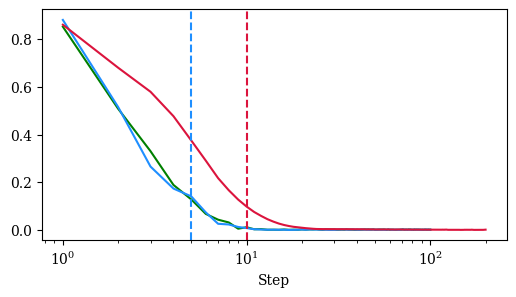

In [237]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
ax.plot(np.arange(100) + 1, y3, color='g')
ax.plot(np.arange(100) + 1, y5, color=blue)
ax.plot(np.arange(200) + 1, y10, color=red)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_xlabel("Step")
ax.axvline(x=5, color=blue, linestyle='--')
ax.axvline(x=10, color=red, linestyle='--')
plt.show()

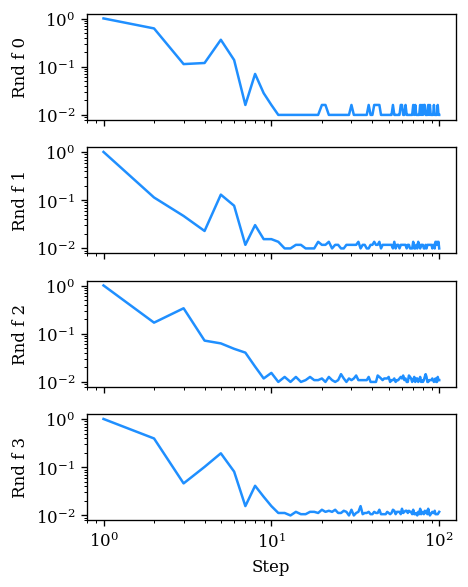

In [197]:
x = np.arange(nsteps) + 1
fig, axs = plt.subplots(m, 1, figsize=(4,5), sharex=True, dpi=120)
for i in range(m):
    axs[i].plot(x, 0.01 + Y[:, i], color=blue)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_ylabel(f"Rnd f {i}")
#     axs[i].axvline(x=150, color='k', linestyle='--')
axs[-1].set_xlabel("Step")
# plt.suptitle("wreath_33/33")
plt.tight_layout()
plt.show()

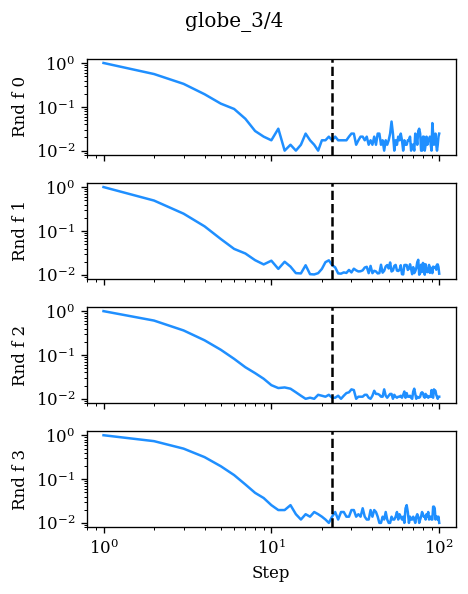

In [141]:
x = np.arange(nsteps) + 1
fig, axs = plt.subplots(m, 1, figsize=(4,5), sharex=True, dpi=120)
for i in range(m):
    axs[i].plot(x, 0.01 + Y[:, i], color=blue)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_ylabel(f"Rnd f {i}")
    axs[i].axvline(x=23, color='k', linestyle='--')
axs[-1].set_xlabel("Step")
plt.suptitle("globe_3/4")
plt.tight_layout()
plt.show()

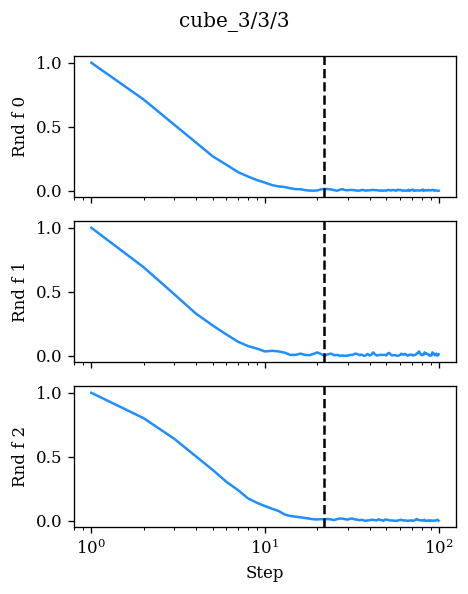

In [122]:
x = np.arange(nsteps) + 1
fig, axs = plt.subplots(m, 1, figsize=(4,5), sharex=True, dpi=120)
for i in range(m):
    axs[i].plot(x, Y[:, i], color=blue)
    axs[i].set_xscale('log')
    axs[i].set_ylabel(f"Rnd f {i}")
    axs[i].axvline(x=21.83, color='k', linestyle='--')
axs[-1].set_xlabel("Step")
plt.suptitle("cube_3/3/3")
plt.tight_layout()
plt.show()